Predict the age of abalone from physical measurements

Начнем с базового шага: импортируем все необходимые библиотеки и загрузим датасет.

In [98]:
from ucimlrepo import fetch_ucirepo 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest

from pandas import DataFrame
import seaborn as sns
import numpy as np

abalone = fetch_ucirepo(id=1) 

abalone.data.original.loc[abalone.data.original['Sex'] == 'M', abalone.data.original.columns == 'Sex'] = 1
abalone.data.original.loc[abalone.data.original['Sex'] == 'F', abalone.data.original.columns == 'Sex'] = 2
abalone.data.original.loc[abalone.data.original['Sex'] == 'I', abalone.data.original.columns == 'Sex'] = 3

data_abalone = abalone.data.original
features = abalone.data.features.columns

X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values
y = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()

Далее выделим наиболее важные признаки для обучения модели, но при том не сильно уменьшим их кол-во.

In [99]:
new_X = SelectKBest(k = 7).fit(X, y).get_feature_names_out(input_features = features)
print(new_X)

data_abalone = data_abalone[['Length','Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']]
X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values

['Length' 'Diameter' 'Height' 'Whole_weight' 'Shucked_weight'
 'Viscera_weight' 'Shell_weight']


Теперь можно визуально оценить зависимости между выбранными признаками и целевой переменной.

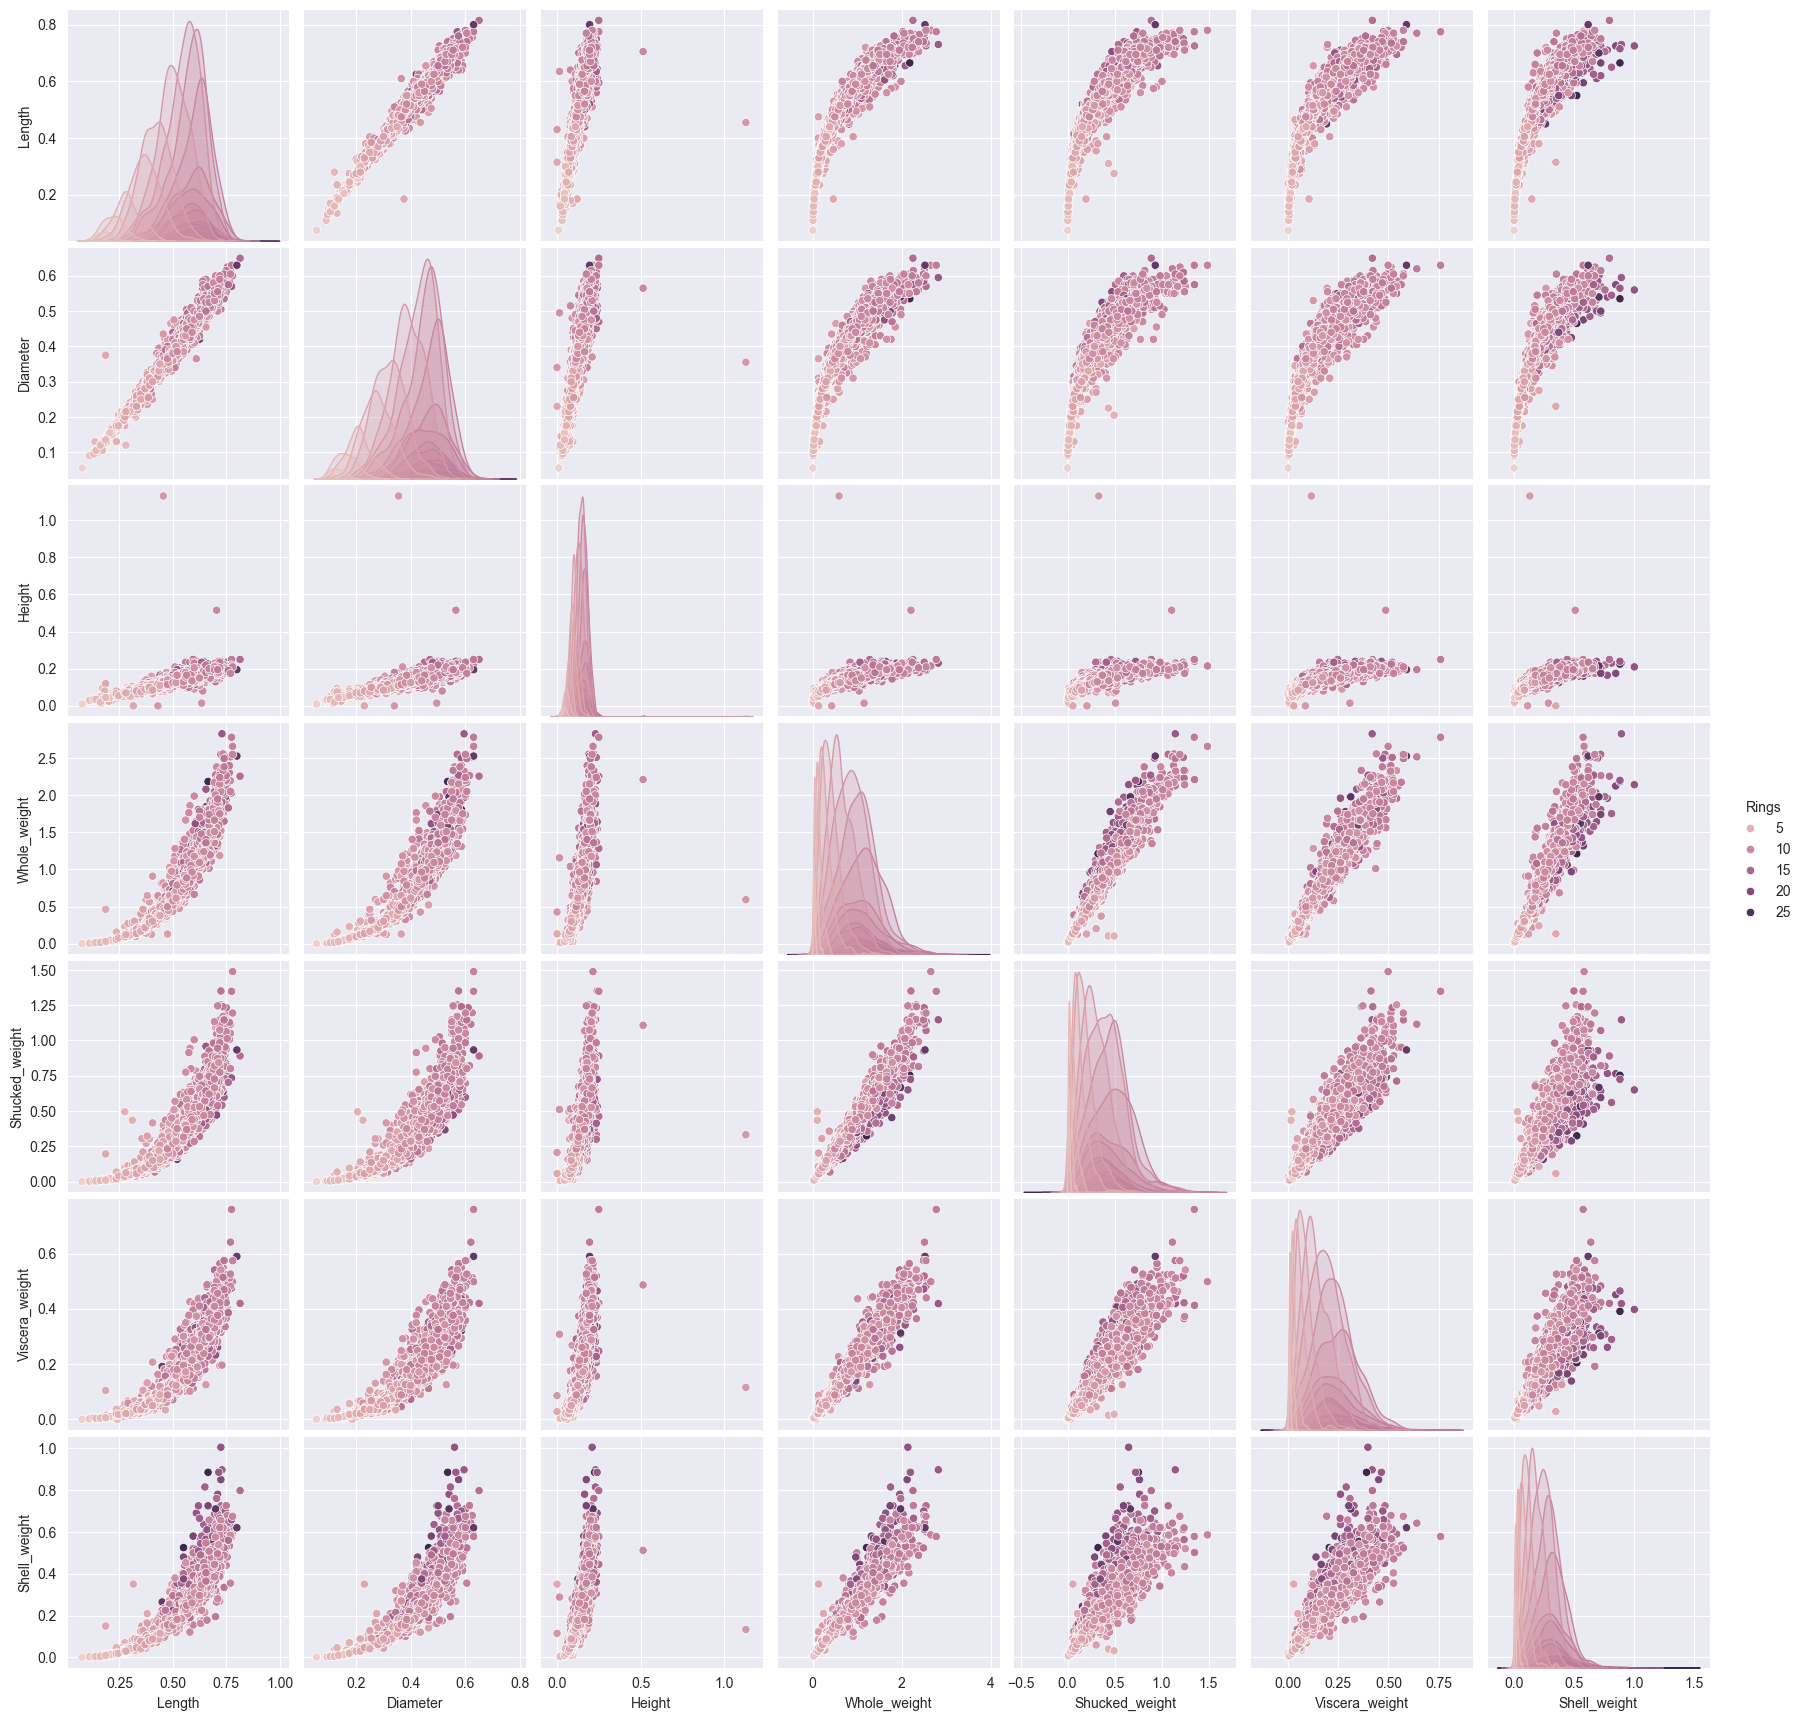

In [100]:
sns.pairplot(data=data_abalone, hue='Rings')

На графиках видно присутствие выбросов, которые могут повлиять на точность модели.
Используем другую визуализацию, чтобы убедиться в этом.

<Axes: >

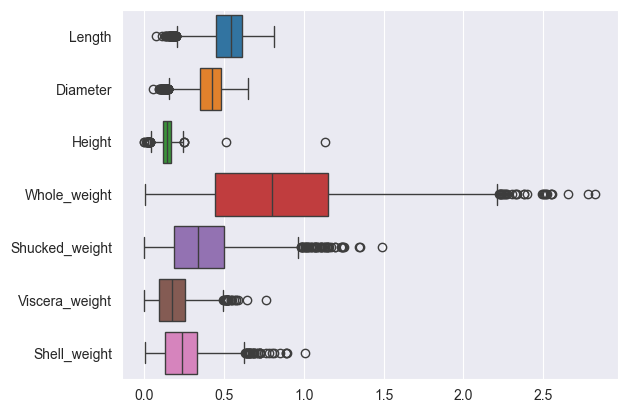

In [101]:
data_features = data_abalone[['Length','Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']]
sns.boxplot(data=data_features, orient='h')

Теперь можно избавиться от выбросов с помощью метода IsolationForest, параметры которого подберем с помощью GridSearchCV.

In [103]:
print(data_abalone.shape)

'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [50, 100, 256],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1, 3, 5]
}

iso_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(iso_forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best:", grid_search.best_params_)
'''

print("Best: {'contamination': 0.01, 'max_features': 1, 'max_samples': 50, 'n_estimators': 100}")

(4177, 8)
Best: {'contamination': 0.01, 'max_features': 1, 'max_samples': 50, 'n_estimators': 100}


In [104]:
data = data_abalone[['Height']]

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples=50,
    contamination=0.01,
    random_state=42)
outliers = iso_forest.fit_predict(data)

data_abalone = data_abalone[outliers != -1]
y = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()

print(data_abalone.shape)

(4144, 8)


Таким образом мы удалили 33 элемента из датасета.
Теперь можно посмотреть на зависимость между признаками и целевой переменной еще раз.

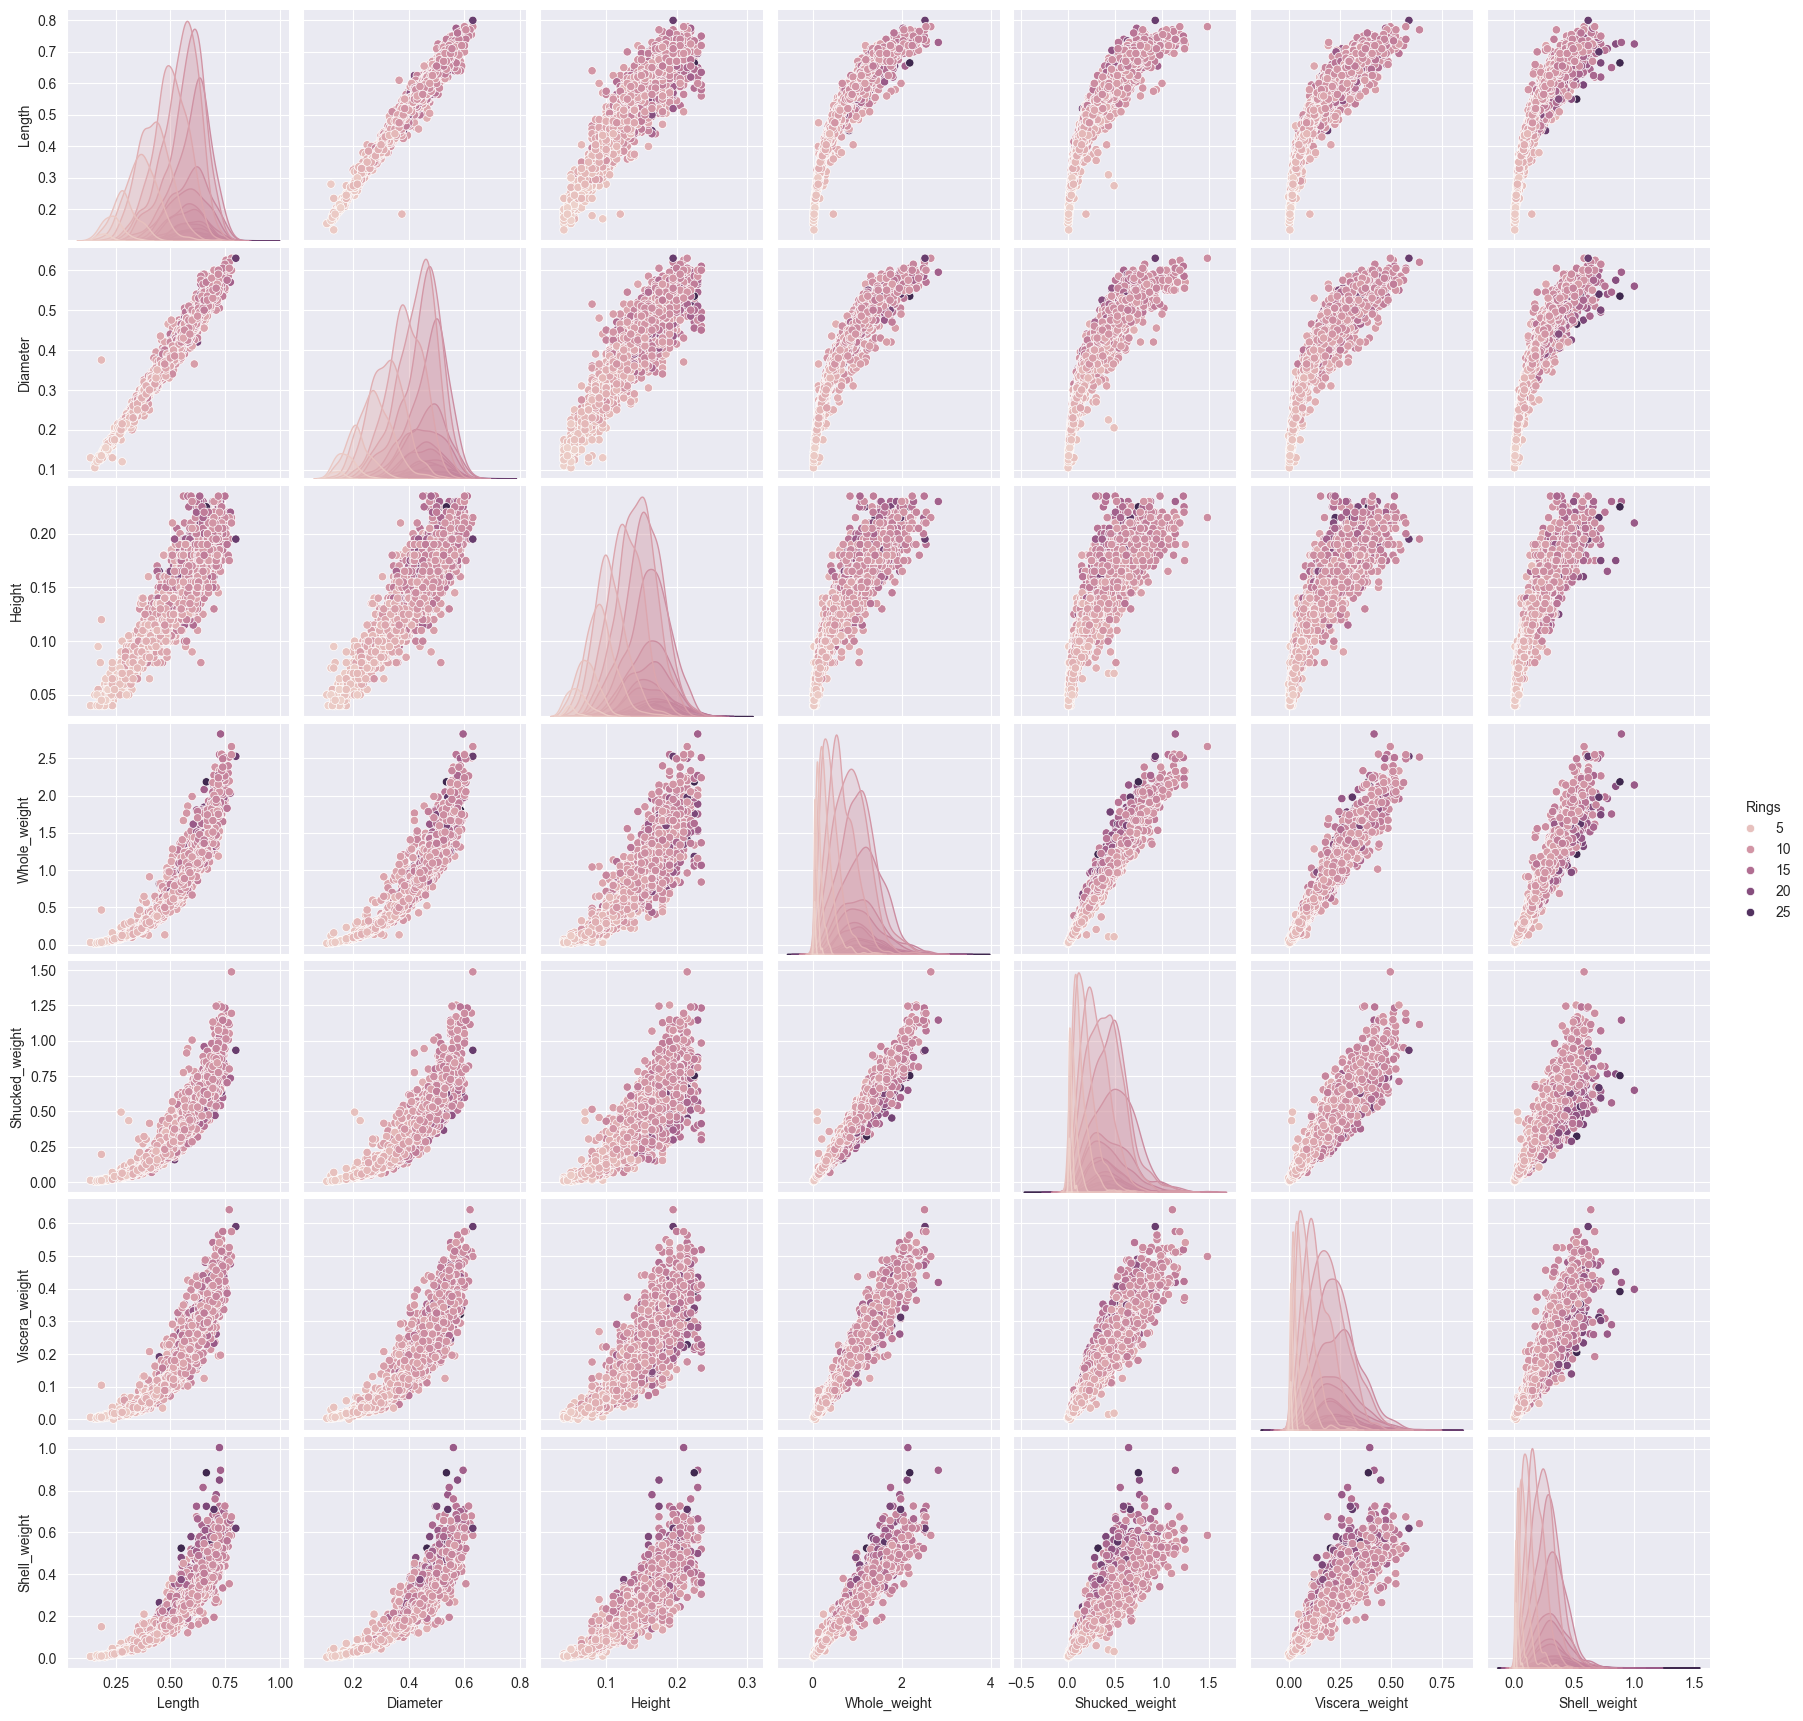

In [105]:
sns.pairplot(data=data_abalone, hue='Rings')

Приступим к обучению моделей, параметры для некоторых из которых подберем также с помощью GridSearchCV.

In [123]:
trg = data_abalone[['Rings']]
trn = data_abalone.drop(['Rings'], axis = 1)
y_train, y_test, X_train, X_test = train_test_split(trg, trn, test_size = 0.4, random_state = 42)

'''
KNN

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

model = KNeighborsRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
'''

print("KNN - Лучшие параметры: {'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}")

'''
RANDOM FOREST

param_grid = {
    'n_estimators': [100, 200, 300],            
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

model = RandomForestRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
'''

print("RF - Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}")

'''
SVC
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 0.1, 0.5, 1]
}

model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
'''

print("SVC - Лучшие параметры: {'C': 100, 'coef0': 0, 'gamma': 'scale'}")

KNN - Лучшие параметры: {'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
RF - Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
SVC - Лучшие параметры: {'C': 100, 'coef0': 0, 'gamma': 'scale'}


Зная параметры приступим к инициализации моделей. 
Их количество достаточно большое, так как мне хотелось посмотреть на работу многих из них.

In [124]:
models = [
    RandomForestRegressor(n_estimators=100, 
                          max_features ='log2',
                          min_samples_leaf = 4,
                          min_samples_split = 10,
                          max_depth = 10,
                          bootstrap = True,
                          random_state=42),
    LinearRegression(),
    KNeighborsRegressor(algorithm = 'brute',
                        n_neighbors = 15,
                        p = 1,
                        weights = 'distance'),
    make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    make_pipeline(PolynomialFeatures(degree=2), KNeighborsRegressor(algorithm = 'brute',
                                                                     n_neighbors = 15,
                                                                     p = 1,
                                                                     weights = 'distance')),
    make_pipeline(PolynomialFeatures(degree=2), RandomForestRegressor(n_estimators=100,
                                                                        max_features ='log2',
                                                                        min_samples_leaf = 4,
                                                                        min_samples_split = 10,
                                                                        max_depth = 10,
                                                                        bootstrap = True,
                                                                        random_state=42)),
    SVC(C=100, coef0=0, gamma='scale', degree = 3, random_state=42),
    Ridge(alpha=1.0),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
]

X_test = X_test.values
X_train = X_train.values
y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

Теперь обучим модели и соберем их результаты по трем метрикам (RMSE, R2, MAE).

In [125]:
training_models = {}
names = ['RFR', 'LR', 'KNN', 'LR_poly', 'KNN_poly', 'RFR_poly', 'SVC', 'Ridge', 'GBR']
RMSE = []
R2 = []
MAE = []

for model in models:
    model.fit(X_train, y_train)
    RMSE.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    R2.append(r2_score(y_test, model.predict(X_test)))
    MAE.append(mean_absolute_error(y_test, model.predict(X_test)))
    
training_models['RMSE'] = RMSE
training_models['R2'] = R2
training_models['MAE'] = MAE

ModelsResults = DataFrame(data=training_models, index=names, columns=['RMSE', 'R2', 'MAE'])
print(ModelsResults)

              RMSE        R2       MAE
RFR       2.159061  0.563164  1.537796
LR        2.217774  0.539082  1.609878
KNN       2.167837  0.559605  1.509981
LR_poly   2.156338  0.564265  1.530511
KNN_poly  2.179554  0.554832  1.521163
RFR_poly  2.137751  0.571744  1.520013
SVC       2.618944  0.357251  1.653800
Ridge     2.243520  0.528319  1.630124
GBR       2.178428  0.555291  1.548157


Представим результаты моделей в виде графика и подведем итоги работы.

<Axes: >

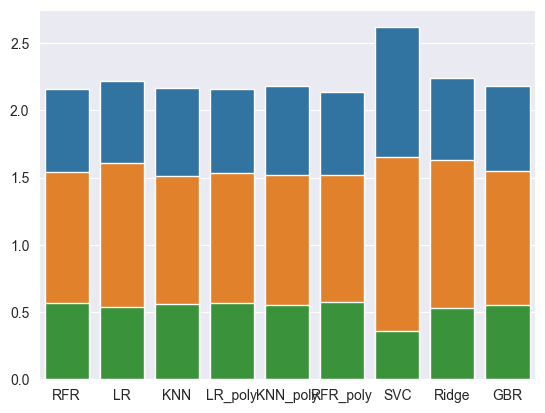

In [109]:
sns.barplot(x=names, y=RMSE)
sns.barplot(x=names, y=MAE)
sns.barplot(x=names, y=R2)

Исходя из результатов, можно сделать вывод, что наилучший результат показала модель RFR с полиномиальными признаками.
Однако стоит отметить, что оценка по R2 говорит о примерном 60% правильном предсказании, что не является столь хорошим результатом.
Посмотрим на график обучения модели, чтобы зафиксировать переобучение.

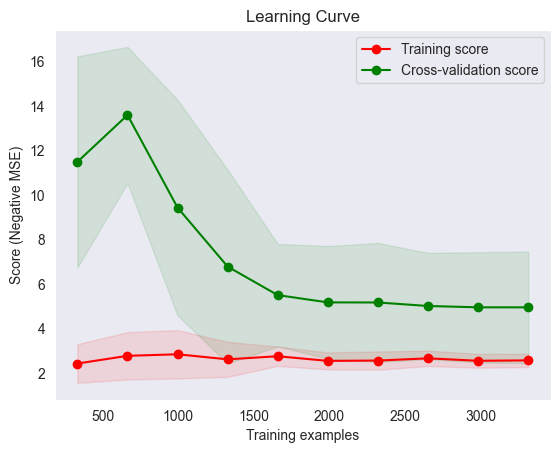

In [129]:
fch = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values
tar = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()
model = make_pipeline(PolynomialFeatures(degree=2), RandomForestRegressor(n_estimators=100,
                                                                        max_features ='log2',
                                                                        min_samples_leaf = 4,
                                                                        min_samples_split = 10,
                                                                        max_depth = 10,
                                                                        bootstrap = True,
                                                                        random_state=42))
model.fit(X_train, y_train)

train_sizes, train_scores, test_scores = learning_curve(
    model, fch, trg, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score (Negative MSE)')
plt.legend(loc="best")
plt.grid()
plt.show()

Данная модель показывает достаточно хорошие результаты и ее можно использовать для дальнейших предсказаний.
Однако видно переобучение из расхождения кривых обучения и валидации, а также сильное недообучение в период обучения на малом кол-ве данных.

In [138]:
pred_data = data_abalone.sample(n = 10)
X_pred = pred_data.iloc[:, pred_data.columns != 'Rings'].values
y_pred = pred_data.iloc[:, pred_data.columns == 'Rings'].values.ravel()

for i in range(10):
    print(y_pred[i], model.predict(X_pred)[i])

7 7.257371275248326
13 10.908687723410937
8 8.055981724286665
20 13.117617694566196
8 8.718840022297558
7 6.849849522247277
10 10.147019407847159
15 14.488725498028916
13 12.977185490554099
7 10.040559820026925


Можно заметить, что чем больше возраст моллюска, тем хуже модель предсказывает его.
Вероятно это связано с тем, что кол-во данный о более возрастных особях значительно меньше, чем о молодых.